# High Order Taylor Maps II

(original by Dario Izzo - extended by Ekin Ozturk)

Building upon the notebook [here](https://darioizzo.github.io/audi/notebooks/example13.html), we show the use of `desolver` for numerically integrating the system of differential equations $\dot{\mathbf y} = \mathbf f(\mathbf y)$:

$$
\begin{array}{l}
\dot r = v_r \\
\dot v_r = - \frac 1{r^2} + r v_\theta^2\\
\dot \theta = v_\theta \\
\dot v_\theta = -2 \frac{v_\theta v_r}{r} + T
\end{array}
$$

which describe, in non dimensional units, the motion of a mass point object around some primary body perturbed by a fixed thrust $T$ acting in the direction perpendicular to the radius vector.
We show how we can build a high order Taylor map (HOTM, indicated with $\mathcal M$) representing the final state of the system at the time $T$ as a function of the initial conditions. 

In other words, we build a polinomial representation of the relation $\mathbf y(T) = \mathbf f(\mathbf y(0), T)$. Writing the initial conditions as $\mathbf y(0) = \overline {\mathbf y}(0) + \mathbf {dy}$, our HOTM will be written as:

$$
\mathbf y(T) = \mathcal M(\mathbf {dy})
$$

and will be valid in a neighbourhood of $\overline {\mathbf y}(0)$.

## Importing Stuff

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import os
import numpy as np

os.environ['DES_BACKEND'] = 'numpy'
import desolver as de
import desolver.backend as D
from desolver.backend import gdual_double as gdual

PyAudi backend is available.
Using numpy backend


In [2]:
T = 1e-3

@de.rhs_prettifier(equ_repr="[vr, -1/r**2 + r*vt**2, vt, -2*vt*vr/r]", md_repr=r"""$$
\begin{array}{l}
\dot r = v_r \\
\dot v_r = - \frac 1{r^2} + r v_\theta^2\\
\dot \theta = v_\theta \\
\dot v_\theta = -2 \frac{v_\theta v_r}{r}
\end{array}
$$""")
def eom_kep_polar(t,y,**kwargs):
    return D.array([y[1], - 1 / y[0] / y[0] + y[0] * y[3]*y[3], y[3], -2*y[3]*y[1]/y[0] - T])

eom_kep_polar

$$
\begin{array}{l}
\dot r = v_r \\
\dot v_r = - \frac 1{r^2} + r v_\theta^2\\
\dot \theta = v_\theta \\
\dot v_\theta = -2 \frac{v_\theta v_r}{r}
\end{array}
$$

In [3]:
# The initial conditions
ic = [1.,0.1,0.,-1.]

## We perform the numerical integration using floats (the standard way)

In [4]:
D.set_float_fmt('float64')
float_integration = de.OdeSystem(eom_kep_polar, y0=ic, dense_output=False, t=(0, 300.), dt=0.01, rtol=1e-10, atol=1e-10, constants=dict())

float_integration.set_method("RK45")
float_integration.integrate(eta=True)

Text(0, 0.5, 'y')

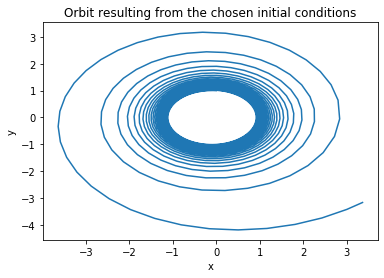

In [5]:
# Here we transform from polar to cartesian coordinates
# to then plot
y = float_integration.y
cx = [it[0]*np.sin(it[2]) for it in y.astype(np.float64)]
cy = [it[0]*np.cos(it[2]) for it in y.astype(np.float64)]
plt.plot(cx,cy)
plt.title("Orbit resulting from the chosen initial conditions")
plt.xlabel("x")
plt.ylabel("y")

## We perform the numerical integration using gduals (to get a HOTM)

In [6]:
# Order of the Taylor Map. If we have 4 variables the number of terms in the Taylor expansion in 329  at order 7
order = 6
# We now define the initial conditions as gdual (not float)
ic_g = [gdual(ic[0], "r", order), gdual(ic[1], "vr", order), gdual(ic[2], "t", order), gdual(ic[3], "vt", order)]

In [7]:
import time
start_time = time.time()
D.set_float_fmt('gdual_double')
gdual_integration = de.OdeSystem(eom_kep_polar, y0=ic_g, dense_output=False, t=(0, 300.), dt=0.01, rtol=1e-10, atol=1e-10, constants=dict())

gdual_integration.set_method("RK45")
gdual_integration.integrate(eta=True)
print("--- %s seconds ---" % (time.time() - start_time))


--- 38.72461462020874 seconds ---


In [8]:
# We extract the last point
yf = gdual_integration.y[-1]
# And unpack it into some convinient names
rf,vrf,tf,vtf = yf
# We compute the final cartesian components
xf = rf * D.sin(tf)
yf = rf * D.cos(tf)
# Note that you can get the latex representation of the gdual
print(xf._repr_latex_())
print("xf (latex):")
xf

\[ 5.27792e+09{dvr}^{2}{dvt}^{2}+2.38683e+07{dr}{dt}{dvr}^{2}+812955{dr}{dt}^{3}{dvt}+0.528723{dt}^{3}-3.96318e+08{dvr}^{3}{dvt}-4.87979e+09{dr}^{2}{dt}{dvt}-1.17038e+16{dr}{dvr}{dvt}^{4}-0.00467575{dt}^{6}+6.75558e+13{dr}{dvr}{dvt}^{3}+1.41974e+12{dr}^{3}{dt}^{2}{dvt}+1.05585e+10{dr}{dt}^{2}{dvr}^{2}{dvt}-4.74308e+17{dr}^{4}{dvt}^{2}-1.9878e+15{dvt}^{6}+1.7157e+13{dr}^{2}{dvr}^{2}{dvt}-2.09573e+12{dr}^{2}{dt}{dvt}^{2}+1.43888e+15{dr}^{4}{dvt}+2.20856e+09{dr}{dvt}^{2}+2.75642e+06{dr}^{2}{dt}^{2}-1.97312e+11{dr}{dt}{dvr}{dvt}^{2}-5.40989e+08{dr}^{3}{dt}^{3}+1.03991e+08{dvr}{dvt}^{2}-1.91427e+07{dt}^{3}{dvr}{dvt}^{2}+3.36654-1.92511e+13{dr}^{2}{dvr}^{4}+689698{dt}^{2}{dvt}^{2}-4.07038e+08{dr}{dt}^{3}{dvt}^{2}-3.93014e+09{dvr}^{6}-6200.56{dr}{dt}-8.73108e+10{dt}{dvt}^{4}+1.43057e+12{dvr}^{2}{dvt}^{3}+4.59063e+08{dr}^{2}{dt}{dvr}-230.032{dr}{dt}^{4}+7.92742e+08{dr}{dvr}^{3}-8.57426e+12{dr}{dvr}^{2}{dvt}^{2}-2.63896e+09{dt}^{2}{dvr}^{2}{dvt}^{2}-93896{dt}^{2}{dvr}^{3}+1.16891e+15{dvr}{dvt}^

Key type        : class obake::polynomials::d_packed_monomial<unsigned __int64,8,void>
Coefficient type: double
Tag             : struct obake::polynomials::tag
Rank            : 1
Symbol set      : {'dr', 'dt', 'dvr', 'dvt'}
Number of terms : 210
5.27792e+09*dvr**2*dvt**2+2.38683e+07*dr*dt*dvr**2+812955*dr*dt**3*dvt+0.528723*dt**3-3.96318e+08*dvr**3*dvt-4.87979e+09*dr**2*dt*dvt-1.17038e+16*dr*dvr*dvt**4-0.00467575*dt**6+6.75558e+13*dr*dvr*dvt**3+1.41974e+12*dr**3*dt**2*dvt+1.05585e+10*dr*dt**2*dvr**2*dvt-4.74308e+17*dr**4*dvt**2-1.9878e+15*dvt**6+1.7157e+13*dr**2*dvr**2*dvt-2.09573e+12*dr**2*dt*dvt**2+1.43888e+15*dr**4*dvt+2.20856e+09*dr*dvt**2+2.75642e+06*dr**2*dt**2-1.97312e+11*dr*dt*dvr*dvt**2-5.40989e+08*dr**3*dt**3+1.03991e+08*dvr*dvt**2-1.91427e+07*dt**3*dvr*dvt**2+3.36654-1.92511e+13*dr**2*dvr**4+689698*dt**2*dvt**2-4.07038e+08*dr*dt**3*dvt**2-3.93014e+09*dvr**6-6200.56*dr*dt-8.73108e+10*dt*dvt**4+1.43057e+12*dvr**2*dvt**3+4.59063e+08*dr**2*dt*dvr-230.032*dr*dt**4+7.92742e+08*d

In [9]:
# We can extract the value of the polinomial when $\mathbf {dy} = 0$
print("Final x from the gdual integration", xf.constant_cf)
print("Final y from the gdual integration", yf.constant_cf)
# And check its indeed the result of the 'reference' trajectory (the lineariation point)
print("\nFinal x from the float integration", cx[-1])
print("Final y from the float integration", cy[-1])

Final x from the gdual integration 3.366536670599516
Final y from the gdual integration -3.172339703511845

Final x from the float integration 3.366536670599606
Final y from the float integration -3.1723397035117493


## We visualize the HOTM

In [10]:
# Let us now visualize the Taylor map by creating a grid of perturbations on the initial conditions and
# evaluating the map for those values
Npoints = 20 # 10000 points
epsilon = 1e-3
grid = np.arange(-epsilon,epsilon,2*epsilon/Npoints)
nxf = [0] * len(grid)**4
nyf = [0] * len(grid)**4
i=0
import time
start_time = time.time()
for dr in grid:
    for dt in grid:
        for dvr in grid:
            for dvt in grid:
                nxf[i] = xf.evaluate({"dr":dr, "dt":dt, "dvr":dvr,"dvt":dvt})
                nyf[i] = yf.evaluate({"dr":dr, "dt":dt, "dvr":dvr,"dvt":dvt})
                i = i+1
print("--- %s seconds ---" % (time.time() - start_time))

--- 23.139215230941772 seconds ---


Text(0.5, 1.0, 'Stretch')

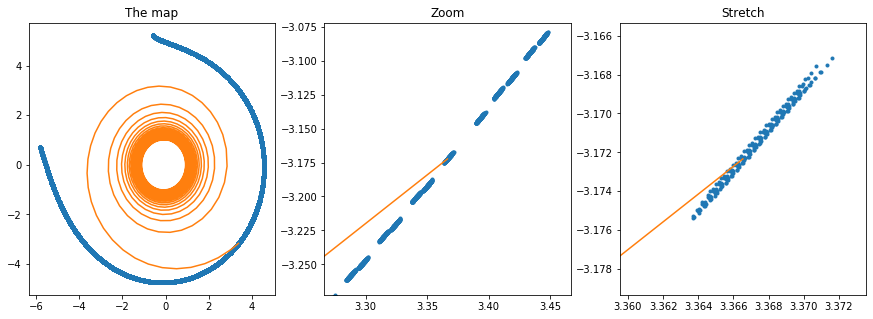

In [11]:
f, axarr = plt.subplots(1,3,figsize=(15,5))
# Normal plot of the final map
axarr[0].plot(nxf,nyf,'.')
axarr[0].plot(cx,cy)
axarr[0].set_title("The map")

# Zoomed plot of the final map (equal axis)
axarr[1].plot(nxf,nyf,'.')
axarr[1].plot(cx,cy)
axarr[1].set_xlim([cx[-1] - 0.1, cx[-1] +0.1])
axarr[1].set_ylim([cy[-1] - 0.1, cy[-1] +0.1])
axarr[1].set_title("Zoom")

# Zoomed plot of the final map (unequal axis)
axarr[2].plot(nxf,nyf,'.')
axarr[2].plot(cx,cy)
axarr[2].set_xlim([cx[-1] - 0.007, cx[-1] + 0.007])
axarr[2].set_ylim([cy[-1] - 0.007, cy[-1] + 0.007])
axarr[2].set_title("Stretch")
#axarr[1].set_xlim([cx[-1] - 0.1, cx[-1] + 0.1])
#axarr[1].set_ylim([cy[-1] - 0.1, cy[-1] + 0.1])

## How much faster is now to evaluate the Map rather than perform a new numerical integration?

In [12]:
# First we profile the method evaluate (note that you need to call the method 4 times to get the full state)

In [13]:
%timeit xf.evaluate({"dr":epsilon, "dt":epsilon, "dvr":epsilon,"dvt":epsilon})

59.5 µs ± 4.74 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
# Then we profile the Runge-Kutta 4 integrator

In [15]:
%%timeit
D.set_float_fmt('float64')
float_integration = de.OdeSystem(eom_kep_polar, y0=[it + epsilon for it in ic], dense_output=False, t=(0, 300.), dt=0.01, rtol=1e-10, atol=1e-10, constants=dict())

float_integration.set_method("RK45")
float_integration.integrate(eta=False)

422 ms ± 31.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0, 0.5, 'Error in estimating the final state (x)')

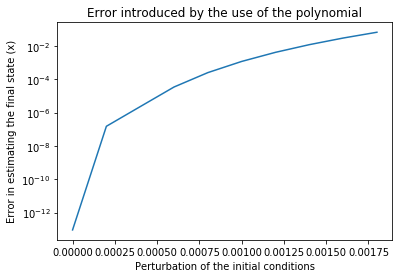

In [16]:
# It seems the speedup is 2-3 orders of magnitude, but did we loose precision?
# We plot the error in the final result as computed by the HOTM and by the Runge-Kutta
# as a function of the distance from the original initial conditions
out = []
pert = np.arange(0,2e-3,2*1e-4)
for epsilon in pert:
    res_map_xf = xf.evaluate({"dr":epsilon, "dt":epsilon, "dvr":epsilon,"dvt":epsilon})
    res_int = de.OdeSystem(eom_kep_polar, y0=[it + epsilon for it in ic], dense_output=False, t=(0, 300.), dt=0.01, rtol=1e-10, atol=1e-10, constants=dict())
    res_int.set_method("RK45")
    res_int.integrate()
    res_int_x = [it.y[0]*np.sin(it.y[2]) for it in res_int]
    res_int_xf = res_int_x[-1]
    out.append(np.abs(res_map_xf - res_int_xf))
plt.semilogy(pert,out)
plt.title("Error introduced by the use of the polynomial")
plt.xlabel("Perturbation of the initial conditions")
plt.ylabel("Error in estimating the final state (x)")